In this dataset it will be to improve the V1


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report,precision_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
data = pd.read_csv('data\Tumeurs.csv')

In [3]:
y = data['label'].copy()
X = data.drop('label', axis=1).copy()
columns_X = X.columns

In [4]:
X = X/255

### Reduce to have the same size in dataset (Class 0, 2, 6 )

Before we have to compute to have the same size : 

In [49]:
data_to_reduce4 = data[data['label']== 4]

data_to_reduce4 = data_to_reduce4.sample(frac=0.015, replace=True, random_state=0)


data_to_reduce6 = data[data['label']== 6]
data_to_reduce6 = data_to_reduce6.sample(frac=0.091, replace=True, random_state=0)

data_to_reduce2 = data[data['label']== 2]
data_to_reduce2 = data_to_reduce2.sample(frac=0.091, replace=True, random_state=0)

data_to_reduce1 = data[data['label']== 1]
data_to_reduce1 = data_to_reduce1.sample(frac=0.2, replace=True, random_state=0)

data_to_reduce0 = data[data['label']== 0]
data_to_reduce0 = data_to_reduce0.sample(frac=0.33, replace=True, random_state=0)

data_to_reduce5 = data[data['label']== 5]
data_to_reduce3 = data[data['label']== 3]

data_stabled = pd.concat((data_to_reduce4, data_to_reduce6, data_to_reduce2, data_to_reduce1, data_to_reduce0, data_to_reduce5,data_to_reduce3))


In [63]:
from scipy import signal
from matplotlib.pyplot import imshow, get_cmap

In [64]:
def displayTwoBaWImages(img1, img2):
    _, axes = plt.subplots(ncols=2)
    axes[0].imshow(img1, cmap=plt.get_cmap('gray'))
    axes[1].imshow(img2, cmap=plt.get_cmap('gray'))

kernel_inccontrast = np.array([[0,0,0,0,0], 
                               [0,0,-1,0,0], 
                               [0,-1,5,-1,0], 
                               [0,0,-1,0,0], 
                               [0,0,0,0,0]])

In [120]:
def preprocessing_data_convolution(data) : 

    X_convolved = []

    #1. Separate the dataset
    y = data['label'].copy()
    print(np.array(y).shape)
    X = data.drop('label', axis=1).copy()
    X = X/255
    X = np.array(X)
    #2. Loop to convolve each images. 
    for image in range(0, len(data)) : 
        image_test = np.array(X[image]).reshape(28,28)
        image_conv  = signal.wiener(image_test, (5,5))
        
        X_convolved.append(image_conv)
        #print(np.array(X_convolved).shape)
        #plt.imshow(image_test, cmap = 'gray')
    return np.array(X_convolved)

result = preprocessing_data_convolution(data_stabled)


(770,)


In [119]:
y = data_stabled['label'].copy()
X = data_stabled.drop('label', axis=1).copy()
y.value_counts()


5    142
3    115
0    108
1    103
4    101
6    101
2    100
Name: label, dtype: int64

In [51]:
columns_X = X.columns

In [52]:
data_stabled.to_csv('data\Tumeurs_data_stabled.csv')



The data is stable. Let's create our NN 

In [140]:

X = np.array(X)
X = X.reshape(770 ,28,28,1)

#X = X.reshape(len(data_stabled),784)

#Scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)


Callback 

In [141]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [142]:
model =tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu" , input_shape = (28, 28, 1)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") , 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu") ,    
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(rate = 0.15), #Important parameter

    tf.keras.layers.Dense(units = 256, activation = 'relu'), 

    tf.keras.layers.Dense(units = 64, activation = 'relu'), 
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(), #Convert 3d in 2d features vectors 
 
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(7,activation = "softmax")])

In [143]:
#model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100,callbacks = [early], validation_data=(X_val, y_val))
#history = model.fit(X_train, y_train, epochs=100,callbacks = [early])

Epoch 1/100


c:\Users\mathi\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


16/16 [==============================] - 1s 29ms/step - loss: 2.4726 - accuracy: 0.2082 - val_loss: 13.1400 - val_accuracy: 0.0926
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 2.1821 - accuracy: 0.2330 - val_loss: 6.7017 - val_accuracy: 0.2037
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 2.0900 - accuracy: 0.2165 - val_loss: 7.0046 - val_accuracy: 0.1852
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 1.9981 - accuracy: 0.2474 - val_loss: 7.9690 - val_accuracy: 0.1852
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 2.0065 - accuracy: 0.2454 - val_loss: 4.8141 - val_accuracy: 0.1667
Epoch 6/100
16/16 [==============================] - 0s 18ms/step - loss: 1.9515 - accuracy: 0.2660 - val_loss: 3.1467 - val_accuracy: 0.1481
Epoch 7/100
16/16 [==============================] - 0s 18ms/step - loss: 1.7831 - accuracy: 0.3278 - val_loss: 1.9891 - val_accuracy: 0.2222
Epoch 8/100
16/16

In [144]:
model_acc = model.evaluate(X_test, y_test)[1]

print("Test Accuracy: {:.3f}%".format(model_acc * 100))

8/8 [==============================] - 0s 5ms/step - loss: 4.0754 - accuracy: 0.1688
Test Accuracy: 16.883%


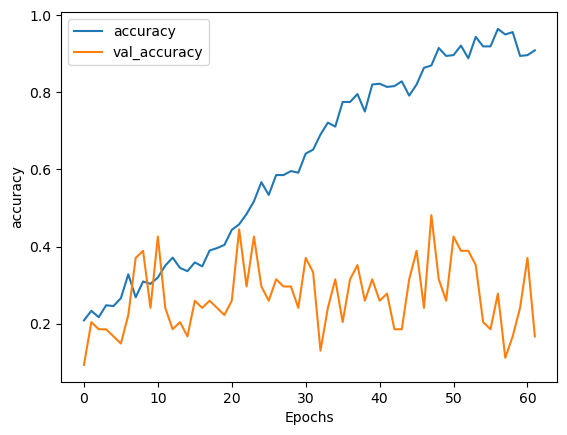

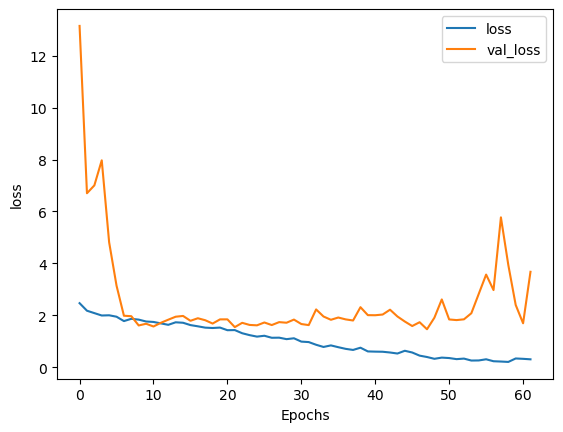

In [145]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

The data is too unstable 

In [101]:
y_true = np.array(y_test)

label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))

cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=label_mapping.values())

c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
y.value_counts()

5    142
3    115
0    108
1    103
4    101
6    101
2    100
Name: label, dtype: int64

c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.50      0.03      0.06        29
           2       0.24      0.52      0.33        27
           3       0.50      0.03      0.05        37
           4       0.25      0.35      0.29        34
           5       0.29      0.77      0.42        44
           6       1.00      0.07      0.12        30

    accuracy                           0.28       231
   macro avg       0.40      0.25      0.18       231
weighted avg       0.39      0.28      0.19       231



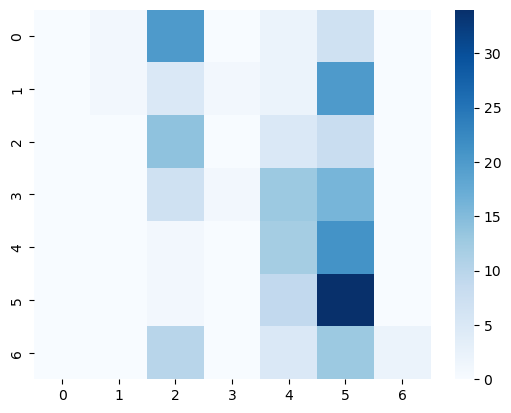

In [103]:
import seaborn as sn

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
cr2 = classification_report(y_test, y_pred)
cm2 = confusion_matrix(y_test, y_pred)
sn.heatmap(cm, cmap='Blues')
print(cr2)
#print(cm) 

In [ ]:
#Cross validation

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression 

X = np.array(X)

X = X.reshape(len(X),784)

lr = LogisticRegression(C =  10.0, penalty =  'l2')


scores = cross_val_score(lr, X, y, cv=5)

In [29]:
scores

array([0.29220779, 0.28571429, 0.30519481, 0.32467532, 0.24675325])

### The class 3, 5 and 6 are well predicted : let's take the train and augmented it to at least reach the 50 in macro avg 

In [24]:
data = pd.read_csv('data\Tumeurs_train.csv')
data = data.drop('Unnamed: 0', axis = 1)
y = data['label'].copy()
X = data.drop('label', axis=1).copy()

X = np.array(X)
X = X.reshape(len(X) ,28,28,1)

#X = X.reshape(len(data_stabled),784)

#Scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)


In [25]:
X_train = pd.DataFrame(np.array(X_train).reshape(len(X_train), 784), columns = columns_X )
y_train = pd.DataFrame(np.array(y_train).reshape(len(y_train), 1), columns = ['label'])
new_data_train = pd.concat((X_train, y_train), axis = 1)


That's better.. Really We have our dataset 

In [52]:
data_to_replace2 = data[data['label']== 2]
data_to_replace2 = data_to_replace2.sample(frac=0.55, replace=True, random_state=0)

data_to_replace1 = data[data['label']== 1]
data_to_replace1 = data_to_replace1.sample(frac=0.2, replace=True, random_state=0)

data_to_replace6 = data[data['label']== 6]
data_to_replace6 = data_to_replace6.sample(frac=0.5, replace=True, random_state=0)


In [53]:
new_data_train.drop( new_data_train[ new_data_train['label'] == 2 ].index, inplace=True)
new_data_train.drop( new_data_train[ new_data_train['label'] == 1 ].index, inplace=True)
new_data_train.drop( new_data_train[ new_data_train['label'] == 6 ].index, inplace=True)


In [54]:
new_data_train

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
4,153,156,184,183,168,186,195,200,200,191,...,175,176,177,168,168,157,136,143,131,0
5,181,184,184,185,186,189,185,187,190,191,...,189,186,186,186,186,185,185,182,181,4
6,161,167,174,151,164,182,184,187,192,192,...,183,178,175,176,171,169,165,163,150,3
7,197,196,197,196,198,196,193,193,193,191,...,183,184,185,183,183,182,180,179,179,4
10,232,236,238,241,243,245,248,249,244,247,...,216,220,222,222,219,218,217,214,209,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,157,156,159,151,154,163,158,158,160,161,...,153,149,149,152,150,146,141,151,146,4
338,111,132,147,156,158,159,152,137,144,152,...,152,164,158,153,142,140,137,134,122,0
339,165,168,169,167,169,171,172,174,173,172,...,164,170,172,170,167,166,168,165,168,5
340,116,123,133,132,135,142,140,142,150,149,...,149,147,146,149,145,141,141,141,142,5


In [55]:
y.value_counts()

5    55
0    42
4    42
3    42
2    28
1    21
6     9
Name: label, dtype: int64

In [56]:
data_train_replaced = pd.concat((data_to_replace2, data_to_replace1, data_to_replace6,new_data_train))

In [57]:
data_train_replaced
y.value_counts()


5    55
0    42
4    42
3    42
2    28
1    21
6     9
Name: label, dtype: int64

In [58]:
data_train_replaced = data_train_replaced.reset_index()
data_train_replaced = data_train_replaced.drop('index', axis = 1)
#data_train_replaced = data_train_replaced.drop('level_0', axis = 1)

In [59]:
data_train_replaced

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,125,141,148,150,145,147,146,144,147,152,...,148,149,148,147,146,136,116,85,42,2
1,92,126,124,140,156,159,160,162,169,173,...,134,158,157,154,142,124,136,145,120,2
2,155,159,161,154,152,151,155,158,160,154,...,131,129,128,128,127,126,137,126,125,2
3,140,148,151,150,153,150,158,157,155,150,...,156,157,157,152,146,141,139,133,136,2
4,140,148,151,150,153,150,158,157,155,150,...,156,157,157,152,146,141,139,133,136,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,157,156,159,151,154,163,158,158,160,161,...,153,149,149,152,150,146,141,151,146,4
276,111,132,147,156,158,159,152,137,144,152,...,152,164,158,153,142,140,137,134,122,0
277,165,168,169,167,169,171,172,174,173,172,...,164,170,172,170,167,166,168,165,168,5
278,116,123,133,132,135,142,140,142,150,149,...,149,147,146,149,145,141,141,141,142,5


In [60]:
y = data_train_replaced['label'].copy()
X = data_train_replaced.drop('label', axis=1).copy()

y.value_counts()

5    55
6    50
0    42
4    42
3    42
2    28
1    21
Name: label, dtype: int64

from files.CNN import cnn